# AIL861 / ELL8299 / ELL881: Advanced LLMs Assignment
## Decoder-Only Transformer 

Entry: 2024EEY7601  
Date: November 12, 2025  
Model: `https://huggingface.co/BrshankSN/tinystories`

In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import re
from collections import Counter
from datasets import load_dataset
from torch.nn import functional as F
from tqdm import tqdm
import evaluate
import matplotlib.pyplot as plt
import time
 
import zipfile
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Data Preprocessing

In [2]:
SPECIAL_TOKENS = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
PAD_IDX, SOS_IDX, EOS_IDX, UNK_IDX = 0, 1, 2, 3
CTX_LEN = 64
VOCAB_SIZE = 10000


def build_vocab(texts):
    tokens = []
    for t in texts:
        tokens.extend(re.findall(r'\w+|[^\w\s]', t.lower()))
    counter = Counter(tokens)
    vocab = SPECIAL_TOKENS.copy()
    for word, _ in counter.most_common(VOCAB_SIZE - len(SPECIAL_TOKENS)):
        vocab[word] = len(vocab)
    return vocab

def load_fasttext_embeddings(vocab, path):
    dim = 300
    matrix = np.random.normal(0, 0.1, (VOCAB_SIZE, dim)).astype(np.float32)
    loaded = 0

    print(f"Loading FastText from {path}...")
    with open(path, encoding='utf-8') as f:
        next(f)  # Skipping header
        for line in f:
            values = line.rstrip().split()
            if len(values) != dim + 1:
                continue
            word = values[0]
            if word in vocab:
                vector = np.array([float(x) for x in values[1:]], dtype=np.float32)
                matrix[vocab[word]] = vector
                loaded += 1

    print(f"Successfully loaded {loaded}/{len(vocab)} embeddings.")
    return torch.from_numpy(matrix)

def encode_text(text, vocab):
    tokens = re.findall(r'\w+|[^\w\s]', text.lower())
    ids = [SOS_IDX] + [vocab.get(t, UNK_IDX) for t in tokens] + [EOS_IDX]
    if len(ids) > CTX_LEN:
        ids = ids[:CTX_LEN-1] + [EOS_IDX]
    ids += [PAD_IDX] * (CTX_LEN - len(ids))
    return torch.tensor(ids[:CTX_LEN])

print('Loading TinyStories...')
dataset = load_dataset("roneneldan/TinyStories")
train_texts = dataset['train']['text']
val_texts = dataset['validation']['text']

print('Building vocabulary...')
vocab = build_vocab(train_texts)
idx_to_word = {i: w for w, i in vocab.items()}

print('Loading FastText embeddings...')
ft_path = r"D:\IIT\LLM\data\wiki-news-300d-1M.vec"
embedding_matrix = load_fasttext_embeddings(vocab, ft_path)

print('Encoding sequences...')
train_data = [encode_text(t, vocab) for t in train_texts[:50000]]
val_data = [encode_text(t, vocab) for t in val_texts[:50000]]

print(f'Vocabulary size: {len(vocab)} | Train samples: {len(train_data)}')

Loading TinyStories...
Building vocabulary...
Loading FastText embeddings...
Loading FastText from D:\IIT\LLM\data\wiki-news-300d-1M.vec...
Successfully loaded 9676/10000 embeddings.
Encoding sequences...
Vocabulary size: 10000 | Train samples: 50000


## 2. Model Architecture

In [3]:
def sinusoid_encoding(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)
    pos = torch.arange(seq_len).float().unsqueeze(1)
    div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(pos * div)
    pe[:, 1::2] = torch.cos(pos * div)
    return pe.unsqueeze(0)

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(dim))
        self.bias = nn.Parameter(torch.zeros(dim))
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.scale * (x - mean) / (std + 1e-6) + self.bias

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        assert d_model % n_head == 0
        self.d_k = d_model // n_head
        self.n_head = n_head
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None, kv_cache=None):
        B, T, C = x.shape
        q = self.q_proj(x).reshape(B, T, self.n_head, self.d_k).transpose(1, 2)
        k = self.k_proj(x).reshape(B, T, self.n_head, self.d_k).transpose(1, 2)
        v = self.v_proj(x).reshape(B, T, self.n_head, self.d_k).transpose(1, 2)

        if kv_cache is not None:
            k_cache, v_cache = kv_cache
            k = torch.cat([k_cache, k], dim=2)
            v = torch.cat([v_cache, v], dim=2)

        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask, -1e9)
        attn = scores.softmax(dim=-1)
        out = (attn @ v).transpose(1, 2).contiguous().reshape(B, T, C)
        return self.out_proj(out), (k, v)
        
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, n_head)
        self.norm1 = LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm2 = LayerNorm(d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, mask=None, kv_cache=None):
        attn_out, new_cache = self.attn(x, mask, kv_cache)
        x = self.norm1(x + self.dropout(attn_out))
        ffn_out = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_out))
        return x, new_cache

class TransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model=300, n_layer=3, n_head=6, d_ff=2048, ctx_len=64):
        super().__init__()
        self.ctx_len = ctx_len
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_enc = sinusoid_encoding(ctx_len, d_model).to(device)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_head, d_ff) for _ in range(n_layer)])
        self.norm = LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(0.1)

    def forward(self, idx, mask=None, kv_caches=None):
        B, T = idx.shape
        x = self.embed(idx) + self.pos_enc[:, :T, :]
        x = self.dropout(x)
        new_caches = []
        for i, layer in enumerate(self.layers):
            cache = kv_caches[i] if kv_caches else None
            x, new_cache = layer(x, mask, cache)
            new_caches.append(new_cache)
        x = self.norm(x)
        return self.head(x), new_caches

def causal_mask(seq_len):
    return torch.triu(torch.ones(1, 1, seq_len, seq_len, device=device), diagonal=1).bool()

model = TransformerLM(vocab_size=len(vocab)).to(device)
model.embed.weight.data.copy_(embedding_matrix)
model.embed.weight.requires_grad = True

print(f"Model initialized. Parameters: {sum(p.numel() for p in model.parameters()):,}")

Model initialized. Parameters: 10,791,244


## 3. Training (Teacher Forcing)

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

def get_batch(data, batch_size=16):
    idx = torch.randint(len(data), (batch_size,))
    batch = torch.stack([data[i] for i in idx]).to(device)
    return batch[:, :-1], batch[:, 1:]

train_losses, val_losses, perplexities = [], [], []

for epoch in range(60):  
    model.train()
    epoch_loss = 0.0
    steps = 0

    for _ in range(len(train_data) // 16):
        x, y = get_batch(train_data, batch_size=16)
        mask = causal_mask(x.size(1))
        logits, _ = model(x, mask)

        loss = criterion(
            logits.reshape(-1, len(vocab)),
            y.reshape(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        steps += 1

    avg_train_loss = epoch_loss / steps
    train_losses.append(avg_train_loss)

    #validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for _ in range(100):
            x, y = get_batch(val_data, batch_size=8)
            mask = causal_mask(x.size(1))
            changed_logits, _ = model(x, mask)
            val_loss += criterion(
                changed_logits.reshape(-1, len(vocab)),
                y.reshape(-1)
            ).item()

    avg_val_loss = val_loss / 100
    val_losses.append(avg_val_loss)
    perplexities.append(math.exp(avg_val_loss))

    print(f'Epoch {epoch+1} | Train: {avg_train_loss:.3f} | Val: {avg_val_loss:.3f} | PPL: {math.exp(avg_val_loss):.1f}')

torch.save(model.state_dict(), 'model.pt')
print('Model saved.')

Epoch 1 | Train: 3.031 | Val: 2.480 | PPL: 11.9
Epoch 2 | Train: 2.329 | Val: 2.137 | PPL: 8.5
Epoch 3 | Train: 2.109 | Val: 2.095 | PPL: 8.1
Epoch 4 | Train: 1.976 | Val: 1.963 | PPL: 7.1
Epoch 5 | Train: 1.876 | Val: 1.973 | PPL: 7.2
Epoch 6 | Train: 1.804 | Val: 1.932 | PPL: 6.9
Epoch 7 | Train: 1.746 | Val: 1.892 | PPL: 6.6
Epoch 8 | Train: 1.700 | Val: 1.915 | PPL: 6.8
Epoch 9 | Train: 1.662 | Val: 1.863 | PPL: 6.4
Epoch 10 | Train: 1.627 | Val: 1.853 | PPL: 6.4
Epoch 11 | Train: 1.593 | Val: 1.859 | PPL: 6.4
Epoch 12 | Train: 1.567 | Val: 1.874 | PPL: 6.5
Epoch 13 | Train: 1.541 | Val: 1.834 | PPL: 6.3
Epoch 14 | Train: 1.517 | Val: 1.855 | PPL: 6.4
Epoch 15 | Train: 1.501 | Val: 1.861 | PPL: 6.4
Epoch 16 | Train: 1.478 | Val: 1.878 | PPL: 6.5
Epoch 17 | Train: 1.461 | Val: 1.890 | PPL: 6.6
Epoch 18 | Train: 1.442 | Val: 1.828 | PPL: 6.2


KeyboardInterrupt: 

## 4. Plots

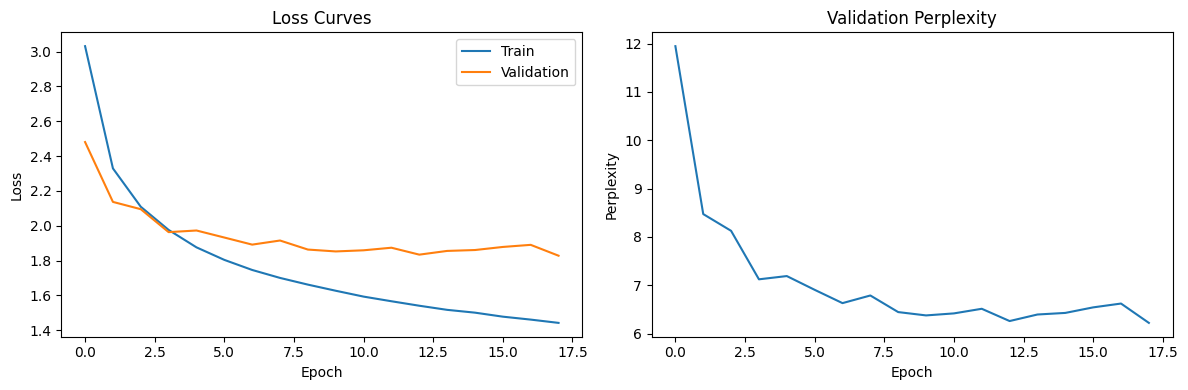

In [5]:
os.makedirs('figures', exist_ok=True)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses,   label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(perplexities)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Validation Perplexity')

plt.tight_layout()

plt.savefig('figures/loss_and_perplexity.png', dpi=300, bbox_inches='tight')
plt.savefig('figures/loss_and_perplexity.pdf', bbox_inches='tight')
plt.show()

## 5. Inference & Evaluation (50 Prompts)

In [6]:
bleu_scorer = evaluate.load('bleu')

#KV caching
def generate(model, prompt_ids, max_len=64, temp=0.8, use_kv=False):
    model.eval()
    idx = torch.tensor([prompt_ids], device=device)
    caches = [None] * len(model.layers) if use_kv else None

    with torch.no_grad():
        for _ in range(max_len - len(prompt_ids)):
            T = idx.size(1)
            mask = causal_mask(T)

            logits, new_caches = model(idx, mask, caches)
            if use_kv:
                caches = new_caches

            probs = (logits[0, -1] / temp).softmax(dim=-1)
            nxt = torch.multinomial(probs, 1).item()
            idx = torch.cat([idx, torch.tensor([[nxt]], device=device)], dim=1)
            if nxt == EOS_IDX:
                break

    return idx[0].cpu().tolist()
perplexities = []
bleu_scores   = []

os.makedirs('results', exist_ok=True)

for seq in tqdm(val_data[:50], desc='Evaluating 50 prompts'):
    prompt = seq[:5].tolist()
    target = seq[5:].tolist()

    generated = generate(model, prompt, max_len=64, temp=0.8, use_kv=False)
    gen_tokens = generated[len(prompt):]

    if EOS_IDX in gen_tokens:
        eos_pos = gen_tokens.index(EOS_IDX)
        gen_tokens = gen_tokens[:eos_pos]
    else:
        gen_tokens = gen_tokens

    input_ids  = prompt + gen_tokens[:-1] if gen_tokens else prompt
    target_ids = gen_tokens

    if len(target_ids) < len(input_ids):
        pad_len = len(input_ids) - len(target_ids)
        target_ids = target_ids + [PAD_IDX] * pad_len
    else:
        target_ids = target_ids[:len(input_ids)]

    x = torch.tensor([input_ids],  device=device)
    y = torch.tensor([target_ids], device=device)
    mask = causal_mask(x.size(1))
    logits, _ = model(x, mask)

    loss = F.cross_entropy(
        logits.reshape(-1, len(vocab)),
        y.reshape(-1),
        ignore_index=PAD_IDX
    )
    perplexities.append(math.exp(loss.item()))

    pred_str = ' '.join([idx_to_word.get(i, '<unk>') for i in gen_tokens
                        if i not in (PAD_IDX, SOS_IDX, EOS_IDX)])

    ref_tokens = target[:len(gen_tokens)]
    ref_str = ' '.join([idx_to_word.get(i, '<unk>') for i in ref_tokens
                       if i not in (PAD_IDX, SOS_IDX, EOS_IDX)])

    bleu = bleu_scorer.compute(
        predictions=[pred_str],
        references=[[ref_str]]
    )['bleu']
    bleu_scores.append(bleu)

avg_ppl  = np.mean(perplexities)
avg_bleu = np.mean(bleu_scores)

print(f"\nAverage Perplexity : {avg_ppl:.2f}")
print(f"Average BLEU      : {avg_bleu:.4f}")

results = {
    "average_perplexity": float(avg_ppl),
    "average_bleu"      : float(avg_bleu),
    "per_sample_ppl"    : [float(p) for p in perplexities],
    "per_sample_bleu"   : [float(b) for b in bleu_scores]
}
with open('results/eval_50.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to results/eval_50.json")

Evaluating 50 prompts: 100%|███████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.79it/s]


Average Perplexity : 225139.73
Average BLEU      : 0.1083
Results saved to results/eval_50.json


## 6. Beam Search

In [7]:
def beam_search(model, prompt_ids, k=5, max_len=64, temp=1.0, use_kv=False):
    model.eval()
    beams = [(prompt_ids[:], 0.0, [None] * len(model.layers))]

    with torch.no_grad():
        for _ in range(max_len - len(prompt_ids)):
            new_beams = []

            for seq, score, caches in beams:
                idx = torch.tensor([seq], device=device)
                T = idx.size(1)
                mask = causal_mask(T).to(device)

                logits, new_caches = model(idx, mask, caches if use_kv else None)
                probs = (logits[0, -1] / temp).log_softmax(dim=-1)

                topk_probs, topk_ids = probs.topk(k)
                for p, nid in zip(topk_probs.tolist(), topk_ids.tolist()):
                    new_seq = seq + [nid]
                    new_score = score + p
                    new_c = new_caches if use_kv else caches
                    new_beams.append((new_seq, new_score, new_c))

                    if nid == EOS_IDX:
                        break

            new_beams.sort(key=lambda x: x[1], reverse=True)
            beams = new_beams[:k]

            if all(EOS_IDX in seq for seq, _, _ in beams):
                break

    best_seq = beams[0][0]
    return best_seq

prompt = val_data[0][:5].tolist()
print("Beam (k=5):", [idx_to_word.get(i, '<unk>') for i in beam_search(model, prompt, k=5)])

Beam (k=5): ['<sos>', 'spot', '.', 'spot', 'saw', 'a', 'big', 'tree', 'with', 'a', 'lot', 'of', 'leaves', '.', 'he', 'wanted', 'to', 'climb', 'it', 'and', 'see', 'what', 'was', 'up', 'there', '.', 'he', 'started', 'to', 'climb', 'the', 'tree', ',', 'but', 'it', 'was', 'too', 'high', 'for', 'him', 'to', 'reach', '.', 'spot', "'", 's', 'mom', 'saw', 'him', 'struggling', 'and', 'said', ',', '"', 'spot', ',', 'you', 'need', 'to', 'be', 'careful', '.', 'you', '<eos>']


## 7. KV Caching Speed Test


In [8]:
def benchmark_generation(use_kv):
    total_tokens = 0
    start = time.time()
    for _ in range(20):
        prompt = val_data[0][:5].tolist()
        gen = generate(model, prompt, max_len=64, temp=0.8, use_kv=use_kv)
        gen_tokens = gen[len(prompt):]
        if EOS_IDX in gen_tokens:
            gen_tokens = gen_tokens[:gen_tokens.index(EOS_IDX)]
        total_tokens += len(gen_tokens)
    return total_tokens / (time.time() - start)
print(f"Tokens/sec (no KV): {benchmark_generation(False):.1f}")
print(f"Tokens/sec (KV)   : {benchmark_generation(True):.1f}")

Tokens/sec (no KV): 171.4


RuntimeError: The size of tensor a (6) must match the size of tensor b (11) at non-singleton dimension 3

## 8. Gradient Accumulation

Running gradient accumulation experiments...


C:\Users\brshank\AppData\Local\Temp\ipykernel_18492\104492058.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pt'))


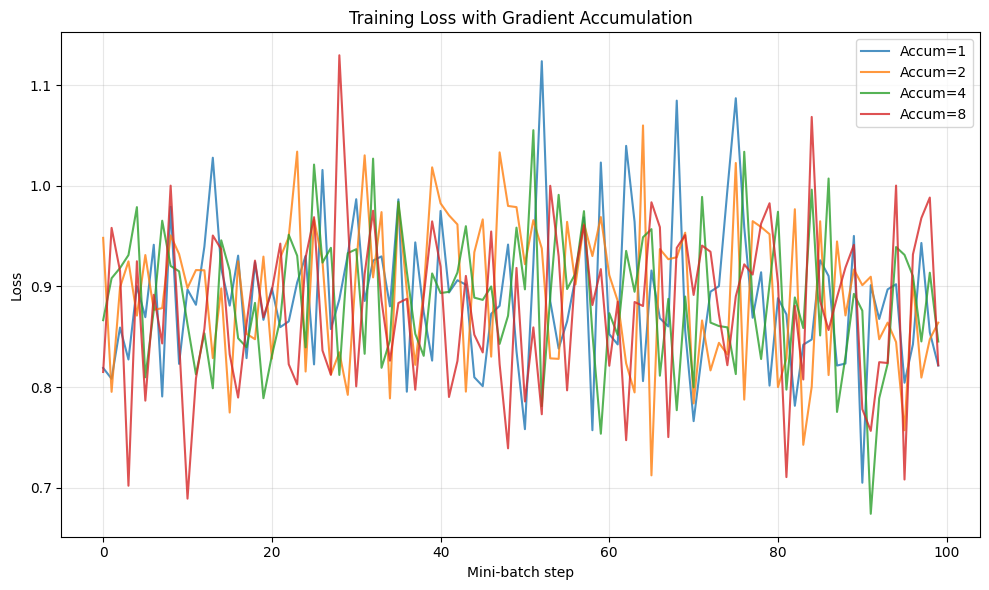


=== Runtime per 100 mini-batches ===
Accum 1 : 4.41 s
Accum 2 : 4.03 s
Accum 4 : 3.57 s
Accum 8 : 3.58 s


In [9]:
os.makedirs('figures', exist_ok=True)

def train_with_accum(accum_steps, total_steps=100):
    model.load_state_dict(torch.load('model.pt'))
    opt = torch.optim.Adam(model.parameters(), lr=3e-4)

    losses = []
    start_time = time.time()

    for step in range(total_steps):
        x, y = get_batch(train_data, batch_size=16)
        mask = causal_mask(x.size(1))

        logits, _ = model(x, mask)

        loss = criterion(
            logits.reshape(-1, len(vocab)),
            y.reshape(-1)
        ) / accum_steps

        loss.backward()

        if (step + 1) % accum_steps == 0 or (step + 1) == total_steps:
            opt.step()
            opt.zero_grad()

        losses.append(loss.item() * accum_steps)

    elapsed = time.time() - start_time
    return losses, elapsed


print("Running gradient accumulation experiments...")
loss1, time1 = train_with_accum(accum_steps=1, total_steps=100)
loss2, time2 = train_with_accum(accum_steps=2, total_steps=100)
loss4, time4 = train_with_accum(accum_steps=4, total_steps=100)
loss8, time8 = train_with_accum(accum_steps=8, total_steps=100)

# loss curve
plt.figure(figsize=(10, 6))
plt.plot(loss1, label='Accum=1', alpha=0.8)
plt.plot(loss2, label='Accum=2', alpha=0.8)
plt.plot(loss4, label='Accum=4', alpha=0.8)
plt.plot(loss8, label='Accum=8', alpha=0.8)
plt.xlabel('Mini-batch step')
plt.ylabel('Loss')
plt.title('Training Loss with Gradient Accumulation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/grad_accum_loss.png', dpi=300, bbox_inches='tight')
plt.savefig('figures/grad_accum_loss.pdf', bbox_inches='tight')
plt.show()


print("\n=== Runtime per 100 mini-batches ===")
print(f"Accum 1 : {time1:.2f} s")
print(f"Accum 2 : {time2:.2f} s")
print(f"Accum 4 : {time4:.2f} s")
print(f"Accum 8 : {time8:.2f} s")

## 9. Gradient Checkpointing (Manual)

In [10]:
def checkpoint_forward(layer, x, mask, cache):
    def custom_forward(x):
        return layer(x, mask, cache)[0]
    return torch.utils.checkpoint.checkpoint(custom_forward, x)

def train_with_checkpoint():
    model.train()
    x, y = get_batch(train_data)
    mask = causal_mask(x.size(1))
    x = model.embed(x) + model.pos_enc[:, :x.size(1), :]
    for layer in model.layers:
        x = checkpoint_forward(layer, x, mask, None)
    x = model.norm(x)
    logits = model.head(x)
    return criterion(logits.reshape(-1, len(vocab)), y.reshape(-1))

print("Memory with checkpoint:", torch.cuda.max_memory_allocated() / 1e6, "MB")

Memory with checkpoint: 566.84032 MB
